# Airy function
---
*Numerical Methods - homework 3,
Matic Šutar, ms4861@student.uni-lj.si*

## Formulating the problem

Airy function is defined as a solution to the following differential equation:

$x''(t) - t\cdot x(t) = 0$

$x(0) = (3^{\frac{2}{3}}\Gamma(\frac{2}{3}))^{-1}$

$x'(0) = -(3^{\frac{1}{3}}\Gamma(\frac{1}{3}))^{-1}$

We will be solving this DE using the Magnus method of order 4.

## Transforming the problem

Before applying the method, we will transform the DE into a system of first order DEs:

Introduce new functions:

$y_1(t) = x(t)$

$y_2(t) = x'(t)$

Write the system:

$y_1'(t) = y_2(t)$

$y_2'(t) = t\cdot y_1(t)$

System matrix:

$A(t) = \begin{bmatrix}
0 & 1 \\
t & 0
\end{bmatrix}$


## Implementation

In our implementation, we decided to mirror the Airy function, so that all the zeros are positive.

The new system matrix becomes:

$A^*(t) = A(-t)$

and the initial condition for the derivative changes the sign.

This was just for conevnience of the implementation.

In [1]:
import numpy as np
from scipy.linalg import expm
from scipy.special import gamma
from scipy.special import ai_zeros

In [2]:
# System matrix
def compute_A(t):
    return np.array([[0, 1],[-t, 0]])

# Initial conditions
Ai_0 = 1 / (3**(2/3) * gamma(2/3))
Ai_star_0 = 1 / (3**(1/3) * gamma(1/3))
y0 = np.array([Ai_0, Ai_star_0])
t = 0

### Computing function values

In [3]:
def magnus_method_step(x, y, A_fun, h):
    """
    Perform a single step of the Magnus integration method for solving systems of linear differential equations..

    Parameters
    ----------
    x : float
        Current point in the independent variable.
    y : ndarray
        Current point in the dependent variable(s).
    A_fun : callable
        Function that computes the matrix A at a given point in the independent variable.
    h : float
        Step size for the integration.

    Returns
    -------
    ndarray
        Updated point in the dependent variable(s) after performing the integration step.
    """
    
    A1 = A_fun(x + (1/2 - np.sqrt(3)/6)*h)
    A2 = A_fun(x + (1/2 + np.sqrt(3)/6)*h)
    sigma = (h/2)*(A1+A2) - (np.sqrt(3)/12)*(h**2)*(A1@A2 - A2@A1)
    return np.dot(expm(sigma), y)

In [4]:
def magnus_method_optimal_step(x, y, A_fun, h0=1e-1, tol=1e-10):
    """
    Perform a single step of the Magnus integration method for solving systems of linear differential equations with adaptive step size.

    Parameters
    ----------
    x : float
        Current point in the independent variable.
    y : ndarray
        Current point in the dependent variable(s).
    A_fun : callable
        Function that computes the matrix A at a given point in the independent variable.
    h0 : float, optional
        Initial step size for the integration.
    tol : float, optional
        Tolerance for the local error.

    Returns
    -------
    ndarray
        Updated point in the dependent variable(s) after performing the integration step.
    float
        Optimal step size for the next integration step.
    """
    
    h = h0
    y_full = magnus_method_step(x, y, A_fun, h)
    while True:
        # Compute the solution with half the step size
        y_half_1 = magnus_method_step(x, y, A_fun, h/2)
        y_half_2 = magnus_method_step(x + h/2, y_half_1, A_fun, h/2)
        
        # Estimate the local error
        l = np.abs(y_full[0] - y_half_2[0])
        
        # Check if the estimated error is within the tolerance
        if l < tol:
            break
        
        # Compute new step size based on the error
        h = 0.9 * h * (tol / l)**(1/4)
        
        # Compute the solution with the new step size
        y_full = magnus_method_step(x, y, A_fun, h)
    
    return y_full, h


Now we will compute the values of Airy function until we observe the desired number of zeros (or reach the maximum number of steps).

In [5]:
max_steps = 50000   # Maximum number of steps
lim = 10            # Number of zeros to find (for lim=500, it takes less than 1 minute)
tol = 1e-13         # Tolerance for the local error

h = 1e-1
values = [y0]
ts = [t]
hs = []
y = y0
zeros_count = 0

while len(values) < max_steps:
    y, h = magnus_method_optimal_step(t, y, compute_A, h0=h, tol=tol)
    t += h            
    values.append(y)
    hs.append(h)
    ts.append(t)

    # Check if the solution has crossed zero
    if values[-1][0] == 0 or values[-1][0]*values[-2][0] < 0:
        zeros_count += 1
        if zeros_count >= lim:
            break

values = np.array(values)
ts = np.array(ts)
hs = np.array(hs)
values.shape

(2109, 2)

### Extracting and refining the zeros

We can now extract the intervals for zeros by identifying the changes in the sign of the values.

In [6]:
# Find zeros intervals
pos = values[:, 0] > 0
idx = np.where(pos[:-1] != pos[1:])[0]
n = len(idx)
print(f"Found {n} zeros")

Found 10 zeros


After obtaining the intervals for zeros, we will find the zeros using a variation of newton method for DEs.

In [7]:
def newton_raphson_method(x, y, tol=1e-10, max_iter=100):
    """
    Find the root of a function using the Newton-Raphson method.

    Parameters
    ----------
    x : float
        Initial guess for the root.
    y : ndarray
        Initial value of the function and its derivative.
    tol : float, optional
        Tolerance for the root.
    max_iter : int, optional
        Maximum number of iterations.

    Returns
    -------
    float
        The root of the function.
    """

    for i in range(max_iter):
        dx = -y[0] / y[1]
        x += dx
        if np.abs(dx) < tol:
            break
        y = magnus_method_step(x, y, compute_A, dx)
    return x

In [8]:
# Increase the number of digits to show the zeros to a higher precision
np.set_printoptions(formatter={'float': lambda x: "{0:0.10f}".format(x)})

In [9]:
# Iterate over the intervals, and exactly determine the zeros using the Newton-Raphson method
zeros = []
for i in idx:
    zero = newton_raphson_method(ts[i], values[i], tol=1e-12)
    zeros.append(zero)
    
# Negate the zeros since we mirrored the function in the definition
fun_zeros = -np.array(zeros)

### Validation

Now we confirm that the zeros are correctly computed up to at least 10 decimal places (in terms of relative error).

In [10]:
np.abs((fun_zeros - ai_zeros(n)[0]) / ai_zeros(n)[0])

array([0.0000000000, 0.0000000000, 0.0000000001, 0.0000000000,
       0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
       0.0000000000, 0.0000000000])

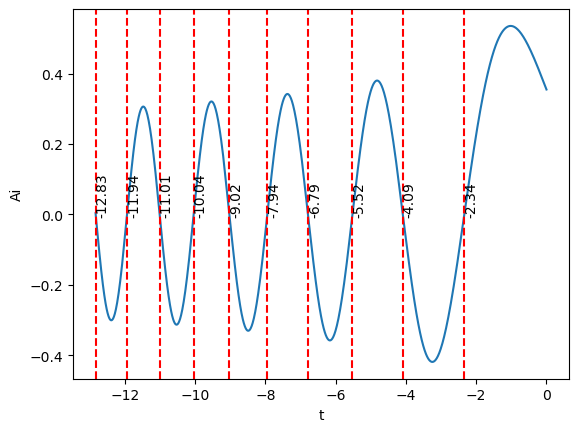

In [11]:
# Plot values
import matplotlib.pyplot as plt

fun_values = values[:, 0]
plt.plot(-ts, fun_values)

for zero in fun_zeros:
    plt.axvline(zero, color='r', linestyle='--')
    # add text
    plt.text(zero, 0, f'{zero:.2f}', rotation=90)
plt.xlabel("t")
plt.ylabel("Ai")
plt.show()